## This notebook introduces the sparse RL framework using an example on the generalized mean-field model (cf. 5.1 of the book here: https://link.springer.com/book/10.1007/978-3-319-40624-4).

### The generalized mean-field model (gmfm) comprises two oscillators, an unstable one $(s_1,s_2)$ and and a stable one $(s_3,s_4)$. The stable oscillator incorporates a forcing term $b$. It has the following dynamics. 
 $\frac{ds_1}{dt} = \sigma s_1 - s_2$ \
 $\frac{ds_2}{dt} = \sigma s_2 + s_1$ \
 $\frac{ds_3}{dt} = -0.1 s_3 - \pi s_4$ \
 $\frac{ds_4}{dt} = -0.1 s_4 + \pi s_3 + b,$ \
 where $\sigma = 0.1 - s_1^2 - s_2^2 - s_3^2 - s_4^2$
 
### The objective is to find a control law minimizing $J = \int_{t=0}^T s_1(t)^2 + s_2(t)^2  + \gamma b(t)^2 dt$ over an interval $[0,T]$, where $\gamma$ is a hyperparameter determining the weighting between the deviation from $(s_1,s_2) = (0,0)$ and the size of the action $b(t)$. 

### We now proceed to the details of the code. The first step is writing down the dynamics in Jax. To do so, we first load the packages that we need to run this notebook.

In [27]:
import jax.numpy as jnp
from jax.experimental.ode import odeint
from jax import jit
from jax import lax
import jax
import time

import itertools
from jax import grad
import jax
import optax

import pickle
import matplotlib.pyplot as plt


from os import path
from typing import Optional

import numpy as np

### Next, the following code implements the dynamics of the gmfm model with forcing, where the forcing is determined based on the parameters $(a,w,p,\beta)$ defining our sparse RL policy. Recall that at any state $s$,  our policy is given as 
$\pi(s) = \frac{1}{\sum_{j=1}^D \alpha_{p_j}(s)}\sum_{j=1}^D \alpha_{p_j}(s) a_{p_j}$, where \
$\alpha_{p_j}(s) := w_{p_j}\exp\left(-\frac{\|s - p_j \|^2}{\beta} \right)$, \
with $\{p_j\}_{j=1}^D$ denoting the coordinates of the $D$ (fixed) anchor points, i.e. only $a$, $w$ and $\beta$ are the trainable parameters.

### An important note: our policy is only based on the first coordinates $(x_1,x_2)$.


In [49]:
# This is 1-step update of gmfm (with forcing) used in odeint
# Input: state s, timespan t, sparse RL parameters {a,w,p,beta}
# Output: ds/dt
def gmfm_forcing_dsdt(s,t,a, w,p,beta):
	alpha_s = jnp.e**(-jnp.linalg.norm(s[:2] - p[:,:2], axis = 1)**2/beta) * w
	pi_s = jnp.dot(alpha_s/jnp.sum(alpha_s), a)
	# jax.debug.print("{x} here, s = {s}", x = jnp.sum(alpha_s), s = s)
	# pi_s  = 1 #just for testing

	sigma = 0.1 - jnp.linalg.norm(s)**2
	dsdt = jnp.empty(len(s))
	dsdt = dsdt.at[0].set(sigma * s[0] - s[1])
	dsdt = dsdt.at[1].set(sigma * s[1] + s[0])
	dsdt = dsdt.at[2].set(-0.1 * s[2] - jnp.pi * s[3])
	dsdt = dsdt.at[3].set(-0.1*s[3] + jnp.pi * s[2] + pi_s)

	return dsdt

# This integrates an ode over a timeseries t for a given ds/dt model (default gmfm_forcing_dsdt)
# Input: ds/dt model, time series vector t, initial point y0, sparse RL parameters {a,w,p,beta}
# Output: y_hist (trajectory), pi_all (corresponding inputs)
def get_ode_res(model = gmfm_forcing_dsdt, t = jnp.linspace(0, 50* jnp.pi,2000), y0 = jnp.zeros(4), 
	args = (jnp.zeros(20), jnp.ones(20), jnp.ones((20,2)), 0.1)):
	a, w,p,beta = args
	ode_res = odeint(model, y0 , t, *args)

	y_hist = ode_res
	#see https://stackoverflow.com/questions/33677183/subtracting-numpy-arrays-of-different-shape-efficiently to understand code below
	alpha_all = jnp.e**(-jnp.linalg.norm(p[:,:2] - y_hist[:,:2][:,None], axis = 2)**2/beta) * w 
	pi_all = jnp.dot(alpha_all/jnp.sum(alpha_all, axis=1)[:,None], a)
	return (y_hist, pi_all)

### We test out the code above first for a sparse RL policy that always applies the zero action, and see what the output trajectory looks like.

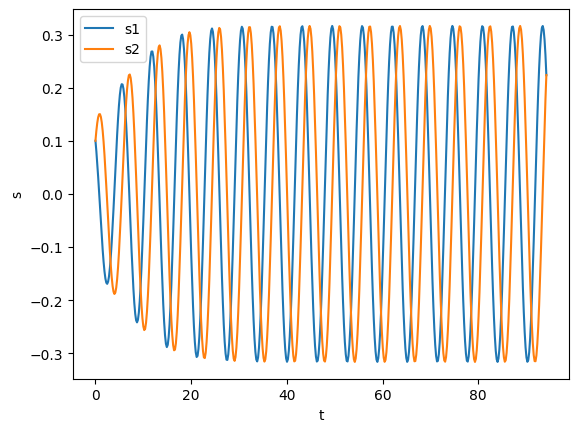

In [75]:
args = (jnp.ones(20), jnp.ones(20), jnp.ones((20,3)), 0.1)
t_vec = jnp.linspace(0,30 * jnp.pi,500)
traj_zero_a, _ = get_ode_res(gmfm_forcing_dsdt,t = t_vec, y0 = jnp.ones(3)*0.1, 
	args = args)
for i in np.arange(2):
    plt.plot(t_vec, traj_zero_a[:,i], label = 's%d'%(i+1))
plt.xlabel('t')
plt.ylabel('s')
plt.legend()
plt.show()

### We next train our sparse RL policy to learn good $(a,w,\beta)$. Note that the feature space our policy is defined on is 2-dimensional (only the first two coordinates $(s_1,s_2)$. 

In [59]:
# The sparse actor object keeps track of a sparse RL policy
# with parameters (a,w,p,beta)
class sparse_actor:
	def __init__(self, a,w,p,beta = 0.1):
		self.a = a
		self.w = w
		self.p = p
		self.beta = beta



# This code initializes an actor for the gmfm model
# Input: initial beta, (D1, D2) (#gridpoints in discretization of s_1,s_2)
# Input(cont'd): s_bounds (lower bdd, upper bdd on feature space)
def init_gmfm_actor(beta  = 0.1, D1 = 10, D2 = 10, s_bounds = [-0.3,0.3]):
	D1 = D1
	D2 = D2
	D = D1 * D2
	p0 = jnp.empty((D,2))
	s1 = jnp.linspace(s_bounds[0], s_bounds[1], D1)
	s2 = jnp.linspace(s_bounds[0], s_bounds[1],D2)
	i = 0
	p0 = jnp.empty((D,2))
	for (xi,yi) in itertools.product(s1,s2):
		p0 = p0.at[i,:].set(jnp.array((xi,yi)))
		i += 1

	a_bounds = jnp.array([-1,1])
	key = jax.random.PRNGKey(3)
	a0 = jax.random.uniform(key, minval = a_bounds[0], maxval = a_bounds[1], shape = (D,))
	w0 = jax.random.uniform(key,shape = (D,)) #[0,1]
	actor = sparse_actor(a0,w0,p0,beta)
	return actor

In [61]:
# Input: params of policy (a,w,p,beta), initial state y0, reference xref
# Input(cont'd): action penalty weight gamma, time vector t, l1_penalty
# Output: cost of policy
def eval_policy(params,p ,y0 = jnp.ones(4),xref = jnp.zeros(2), gamma = 0.1, t = jnp.linspace(0, 30 * jnp.pi,500), l1_penalty = 0.01):
	policy = [params['a'],params['w'],p,params['beta']]
	# policy = [params['a'],params['w'],p,beta]
	# print(len(policy))
	y_all, pi_all = get_ode_res(gmfm_forcing_dsdt,t = t,y0 = y0, args = policy)
	policy_cost = jnp.mean(jnp.linalg.norm(y_all[:,:2], axis = 1)**2) + gamma * jnp.mean(pi_all **2)
	l1_cost =  l1_penalty * jnp.linalg.norm(params['w'], ord = 1)
	J = policy_cost + l1_cost
# 	jax.debug.print("policy cost is {x} here, l1 cost = {s}", x = policy_cost, s = l1_cost)
	return J

In [60]:
# Output: trained policy for environment (default gmfm) after K (= max_iters) iterations
def train(env = 'gmfm', print_freq = 50, max_iters = 500):
    #first init sparse actor
    if env == 'gmfm':
        actor = init_gmfm_actor(beta = 0.1)
        y0 = jnp.array([0.3162,0.0051,0,0])
        a_bounds = jnp.array([-1,1])
        xref = jnp.array([0,0])
        eval_policy_fn = eval_policy
        xref = jnp.array([0,0])
        t_vec = jnp.linspace(0, 30 * jnp.pi,500)

    #next train sparse actor
    beta_bounds = jnp.array([0,1])
    optimizer = optax.adabelief(1e-3)
    params = {'a': actor.a, 'w':actor.w, 'beta': actor.beta}
    opt_params = optimizer.init(params)
    init_res = eval_policy_fn(params, actor.p,y0, xref, t = t_vec)
    for i in range(max_iters):
        grads = jax.grad(eval_policy_fn)(params, actor.p,y0, xref,t = t_vec)
        updates,opt_params = optimizer.update(grads, opt_params)
        params = optax.apply_updates(params,updates)
        params['a'] = jnp.where(params['a'] < a_bounds[0], a_bounds[0], params['a'])
        params['a'] = jnp.where(params['a'] > a_bounds[1], a_bounds[1], params['a'])
        params['w'] = jnp.where(params['w'] < 0, 0, params['w'])
        params['w'] = jnp.where(params['w'] > 1, 1, params['w'])
        params['beta'] = jnp.where(params['beta'] < 0.001, 0.001, params['beta'])

        if i % print_freq == 0 or i == max_iters - 1:
            print(f"iter{i} done, cost is: ", eval_policy_fn(params,actor.p,y0,xref))
            
    a = params['a']
    w = params['w']
    p = actor.p
    beta = params['beta']
    actor = sparse_actor(a,w,p,beta)
    return(actor)

In [63]:
t1 = time.time()
env = "gmfm"
actor = train(env)
print("this took %.1f seconds" % (time.time() - t1))

iter0 done, cost is:  0.65839833
iter50 done, cost is:  0.47500694
iter100 done, cost is:  0.3088087
iter150 done, cost is:  0.13347141
iter200 done, cost is:  0.02193714
iter250 done, cost is:  0.0052157408
iter300 done, cost is:  0.0052839937
iter350 done, cost is:  0.0055412874
iter400 done, cost is:  0.0050769206
iter450 done, cost is:  0.0051860567
iter499 done, cost is:  0.004928631
this took 49.8 seconds


In [64]:
actor.beta

Array(0.001, dtype=float32)

### Let us now visualize the performance of the trained policy. Observe that the algorithm is able to stabilize the unstable oscillator near the origin (at least until near the end of the time interval)

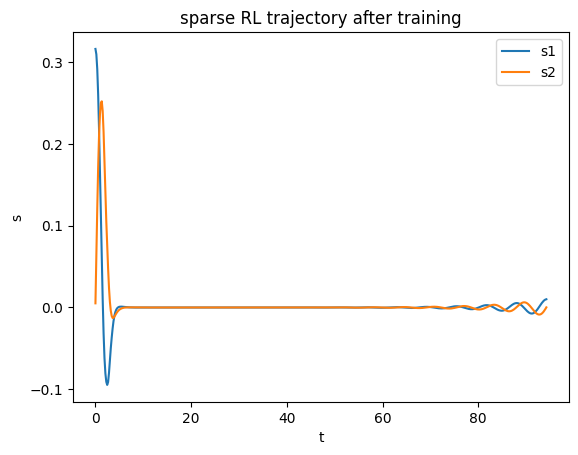

In [74]:
policy = [actor.a,actor.w,actor.p,actor.beta]
t_vec = jnp.linspace(0,30 * jnp.pi,500)
y0 = jnp.array([0.3162,0.0051,0,0])
traj, pi_hist = get_ode_res(gmfm_forcing_dsdt,t = t_vec, y0 = y0, 
    args = policy)
for i in np.arange(2):
    plt.plot(t_vec, traj[:,i], label = 's%d'%(i+1))
plt.xlabel('t')
plt.ylabel('s')
plt.title('sparse RL trajectory after training')
plt.legend()
plt.show()

### Next, we show the heatmap of the learned weight vector $w$

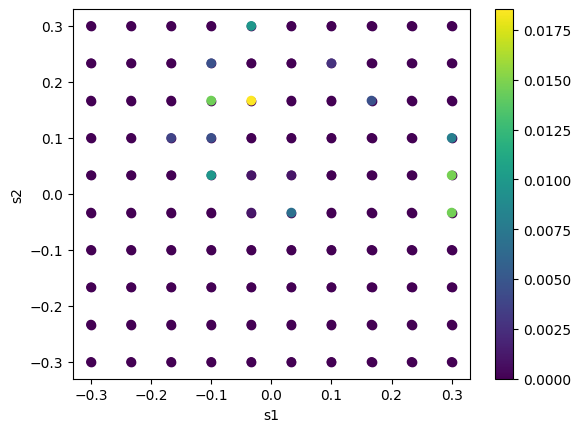

In [71]:
p = actor.p
w = actor.w
plt.scatter(p[:,0],p[:,1], c = "#440154")
plt.scatter(p[:,0],p[:,1], c = w, cmap = 'viridis')
plt.xlabel("s1")
plt.ylabel("s2")
plt.colorbar()